In [1]:
import pandas as pd
from langchain_aws import BedrockLLM, BedrockEmbeddings
import boto3
import json
from utils import *

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_csv('all_data_s3/samples/sample_1000_dining_vendors.csv')
formated_df = format_dataframe_atena(df)

# Visualize Data

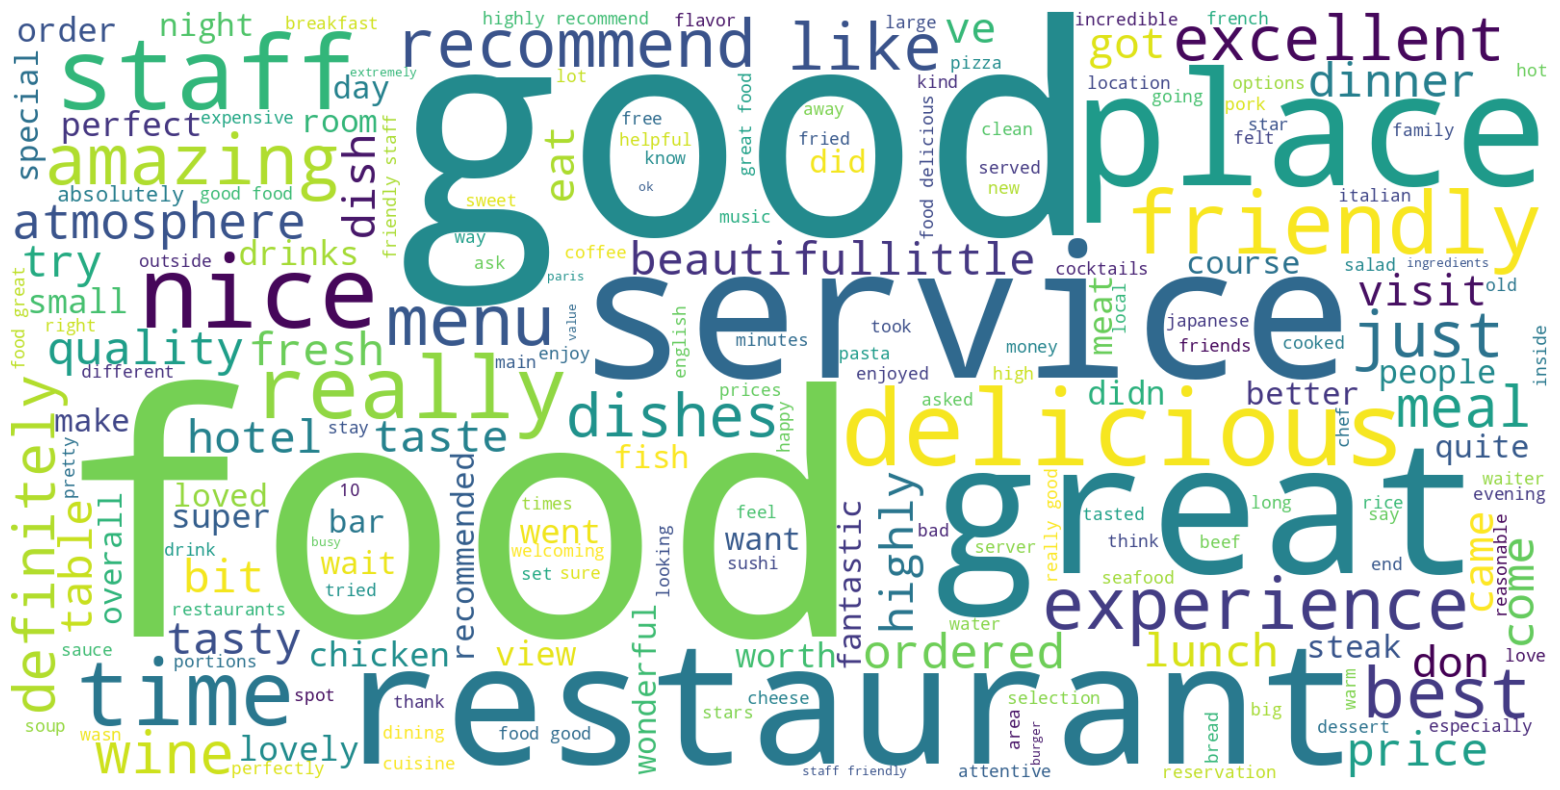

In [3]:
comments = [review['text'] for reviews in formated_df['reviews'] if reviews for review in reviews ]
ngrams_freq = get_ngrams(comments, (1,2))
show_wordcloud_of_ngrams(ngrams_freq)

# Analyze Reviews

In [12]:
AWS_MODEL_ID = 'mistral.mistral-7b-instruct-v0:2' #'meta.llama3-8b-instruct-v1:0' 
REGION = 'eu-west-3'#'us-west-2' #
llm = create_llm(REGION, AWS_MODEL_ID)

template = """- You are an expert in analyzing and classifying restaurant information based on customer reviews.
- Extract the following information from the reviews and the restaurant summary.
- Provide the output in JSON format without any additional text

The following categories to extract are mandatory:
- **Cuisine Type**: Identify the style of cuisine (e.g., French, Italian, Japanese). Respond "Unknown" if it is unclear.
- **Specialties**: Highlight any signature dishes or unique offerings mentioned.
- **Dietary Options**: Note any available dietary accommodations (e.g., vegan, gluten-free, vegetarian...). You can also deduce it from mentionned dishes. 
- **Restaurant Style**: Describe the decor or setting of the restaurant (e.g., modern, rustic, traditional...).
- **Atmosphere**: Indicate the ambiance of the restaurant (e.g., casual, fine dining, family-friendly, romantic...).
- **Terrace**: Specify whether the restaurant has a terrace or outdoor seating area. Possible values : Yes, No, Unknown
- **View**: Describe any notable views (e.g., ocean view, cityscape...). Strict Possible values : Yes, No, Unknown
- **Price Range**: Specify the average cost per person or the general price range if available.

If any of these categories is not mentioned in the reviews, respond with "Unknown"
Optional : If you find other important information like dress code or parking infos put them in "Additional Info" key

######
Example :
Restaurant description:
A modern Japanese restaurant offering a variety of fresh sushi, including vegan and gluten-free options.

Customer Reviews:
I loved the sushi here, especially the spicy tuna roll. The restaurant has a sleek, modern decor and offers gluten-free options. Prices are reasonable, around $25 per person.

Great place for a casual dinner! The sushi is fresh and there are vegan options. The ambiance is relaxed, and the prices are affordable at about $20 per person.

Output:
```json
{{
  "Cuisine Type": "Japanese",
  "Specialties": ["Sushi", "Spicy tuna roll"],
  "Dietary Options": ["Gluten-free", "Vegan"],
  "Restaurant Style": "Modern",
  "Atmosphere": "Casual",
  "Terrace": "Unknown",
  "View": "Unknown",
  "Price Range": "$20 to $25 per person"
}}
######

<<<
Restaurant description:
{description}

Customer Reviews:
{reviews}
<<<

Output:
"""

In [23]:
# Create the PromptTemplate object
prompt = PromptTemplate(
    input_variables=["description", "reviews"],
    template=template
)
# Set up a parser + inject instructions into the prompt template.
parser = JsonOutputParser()
prompt_output = prompt.invoke({
    "description": formated_df["editorial_summary"],
    "reviews": "\n".join([review['text'] for review in formated_df['reviews'][0]]),
})
llm.invoke(prompt_output)
answer = llm.invoke(prompt_output)
prejson = answer.split('```')[1]
parser.invoke(prejson.replace('json',''))

{'Cuisine Type': 'Japanese',
 'Specialties': ['Lamb rib yaki', 'Sushi', 'Shiok maki'],
 'Dietary Options': 'Unknown',
 'Restaurant Style': 'Unknown',
 'Atmosphere': 'Unknown',
 'Terrace': 'Unknown',
 'View': 'Unknown',
 'Price Range': 'Unknown',
 'Additional Info': {'Waiting Time': 'Long',
  'Queue': 'Long',
  'Location': 'Top floor of Wisma, need to go thru food republic to get to the restaurant'}}

In [7]:
answer

'```json\n{\n  "Cuisine Type": "Japanese",\n  "Specialties": ["Lamb rib yaki", "Sushi", "Shiok maki"],\n  "Dietary Options": "Unknown",\n  "Restaurant Style": "Unknown",\n  "Atmosphere": "Unknown",\n  "Terrace": "Unknown",\n  "View": "Unknown",\n  "Price Range": "Unknown",\n  "Additional Info": {\n    "Waiting Time": "Long",\n    "Queue": "Long",\n    "Location": "Top floor of Wisma, need to go thru food republic to get to the restaurant"\n  }\n}\n```'

In [19]:
raw_input_output = {}

In [ ]:
enriched_content = {}
for i, row in formated_df.iterrows():
    try:
        print(i)
        if row['reviews']:
            prompt_input = prompt.invoke({
                "description": row["editorial_summary"] if row["editorial_summary"] else "",
                "reviews": "\n".join([review['text'] for review in row['reviews']])
            })
            raw_input_output[row['vendor_id']] = {'input': prompt_input.text}
            
            output = llm.invoke(prompt_input)
            raw_input_output[row['vendor_id']]['output'] = output
            
            prejson = output.split('```')[1].replace('json','') if '```' in output else output.replace('json','')
            final_json = parser.invoke(prejson)
            enriched_content[row['vendor_id']] = final_json
        else:
            enriched_content[row['vendor_id']] = {}
    except Exception as e:
        print(e)
        print(output)

In [26]:
json.dump(raw_input_output, open('raw_input_output_dining.json','w'))

In [64]:
check_json_output(enriched_content)

Number of vendors treated :  99
Number of vendors without reviews (enrichment is None) :  0
Counter({'Cuisine Type': 97, 'Specialties': 97, 'Dietary Options': 97, 'Restaurant Style': 97, 'Atmosphere': 97, 'Terrace': 97, 'View': 97, 'Price Range': 97, 'Additional Info': 50})


In [70]:
mandatory_columns = ['Cuisine Type','Specialties','Dietary Options','Restaurant Style','Atmosphere','Terrace','View','Price Range']
llm_df = add_enriched_content_to_dataframe(enriched_content, mandatory_columns)
llm_df.to_csv(f"Restaurants Generations/{AWS_MODEL_ID.replace('.','-')} - generated_data_100.csv",index=False)

In [93]:
len(llm_df)

99

In [94]:
full_df = pd.merge(llm_df, formated_df, on='vendor_id', how='left')
full_df.to_csv(f"Restaurants Generations/{AWS_MODEL_ID.replace('.','-')} - full_data_100.csv",index=False)